# Classification
### Hands-On Machine Learning with SciKit-Learn, Keras & Tensorflow, 2nd ed. - A. Géron

### MNIST
The MNIST dataset contains 70,000 images of handwritten digits

In [3]:
# Download the MNIST dataset

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [4]:
import numpy as np

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]



(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

 - The 70,000 images each have 784 features
 - Each feature represents pixel intensity in a 28 x 28 grid

In [5]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

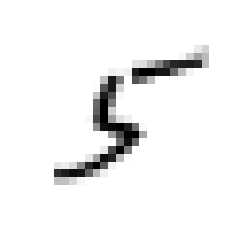

In [6]:
# Plot the first digit

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[35000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
y[35000]

5

The MNIST dataset is already shuffled and split into a training set (the first 60,000 images), and test set (the last 10,000 images).

In [8]:
# Split the training and test sets

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a Binary Classifier
 -  For now, we will try to identify only one digit, "5"
 - This is a binary classifier, capable of distinguishing between two classes

In [10]:
# Create the target vectors

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
y_test_5

array([False, False, False, ..., False, False, False])

We will use Stochastic Gradient Descent (SGD), which can handle large datasets efficiently

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

In [13]:
# Predict the digit from the image of a 5 shown earlier

sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

#### Cross-Validation

We will use the cross_val_score() function to evaluate our model, using K-fold cross-validation with three folds.

This means splitting the training set into three folds, making predictions, then evaluating them on each fold using a model trained on the remaining folds

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9628 , 0.96635, 0.96115])

As only about 10% of images are 5s, if you always guess that the image is not a 5, you will be right about 90% of the time. 

This is why accuracy is not the preferred measure for classifiers, especially when dealing with skewed datasets (when some classes are much more frequent than others).

#### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix.

The general idea is to count the number of times instances of class A are classified as class B.

For example, to know the number of times the classifier confused a 5 with a 3, you would look in the fifth row and third column of the matrix.

You first need a set of predictions so they can be compared to the actual targets.

In [15]:
# Perform three-fold cross-validation and return the predictions made on each fold

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
# Generate confusion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53469,  1110],
       [ 1084,  4337]], dtype=int64)

**The first row is the negative class and considers non-5 images**
 - 53,568 non-5s were correctly classified as non-5s (*true negatives*)
 - 1,011 were wrongly classified as 5s (*false positives*)

**The second row is the positive class and considers the images of 5s**
 - 1,269 were wrongly classified as non-5s (*false negatives*)
 - 4,152 were correctly classified as 5s (*true positives*)

#### Precision and Recall

The confusion matrix gives a lot of information, but a more concise metric may be preferred.

*Precision* of the classifier looks at the accuracy of the positive predictions.
$$
precision = \frac{TP}{TP + FP}
$$
TP = true positives
<br>FP = false positives

Precision is typically used with another metric called *recall*, also called *sensitivity*, or the *true positive rate* (TPR). This is the ratio of positive instances that are correctly detected by the classifier.
$$
recall = \frac{TP}{TP + FN}
$$
FN = false negatives

In [17]:
# Calculate precision and recall

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

print(f'precision: {precision:.4f} recall: {recall:.4f}')

precision: 0.7962 recall: 0.8000


When the model claims an image is a 5, it is correct 80.42% of the time and detects 76.59% of them.

It is often convenient to combine the precision and recall into one metric called the F<sub>1</sub> score.

The F<sub>1</sub> score is the *harmonic mean* of precision and recall. The harmonic mean gives more weight to low values, therefore the classifier will only get a high F<sub>1</sub> score if both the recall and precision are high.

$$
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN+FP}{2}}
$$

In [18]:
# Compute the F1 score

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7981229297018769

The F<sub>1</sub> score favours classifiers that have similar precision and recall. This is not always what you want, sometimes you might prioritise precision over recall.

Increasing precision reduces recall and vice versa. This is the *precision/recall trade-off*

#### Precision/Recall Trade-Off

SGDClassifier computes a score based on a decision function and assigns a class based on if the score is above or below a threshold. Raising the threshold increases precision and decreasing the threshold increases recall.

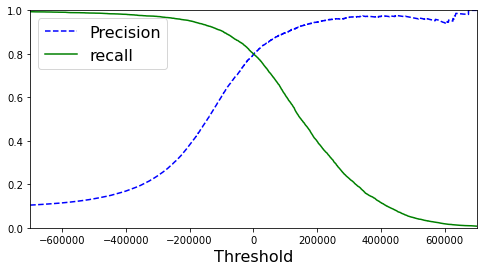

In [19]:
# Plot precision and recall for different threshold values

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function')

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

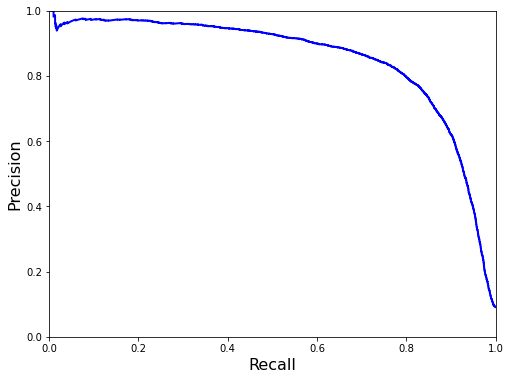

In [20]:
# Plot precision against recall

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [21]:
# Get the lowest threshold that gives you at least 90% precision

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [22]:
# Make predictions

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [23]:
# Calculate precision and recall

precision = precision_score(y_train_5, y_train_pred_90)
recall = recall_score(y_train_5, y_train_pred_90)

print(f'precision: {precision:.4f} recall: {recall:.4f}')

precision: 0.9001 recall: 0.5982


#### The ROC Curve

The *reciever operating characteristic* (ROC) curve plots the TPR against the FPR. The FPR is the false positive rate is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - the *true negative rate*. The true negative rate is the ratio of negative instances that are correctly classified as negative. The TNR is also called *specificity*. The ROC plots *sensitivity* against 1 - *specificity*

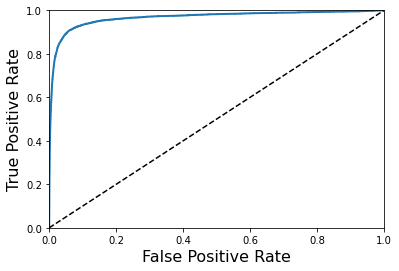

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
plot_roc_curve(fpr, tpr)
plt.show()

There is also a trade-off. The higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents a purely random classifier.

Another way to compare classifiers is to use the *area under the curve* (AUC). A perfect classifier will have a ROC AUC of 1, a purely random classifier will have a ROC AUC of 0.5.

In [25]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9664593724899156

In general the PR curve is preferred when the positive class is rare, and the ROC otherwise.

We can train a random forest classifier and compare its ROC curve and ROC AUC score to the SGD classifier.

In [26]:
# Train a random forest classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')

In [27]:
# Use the positive class probability as the score

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

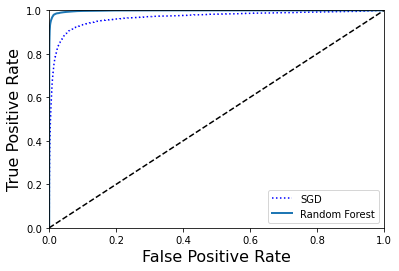

In [28]:
# Plot the two ROC curves

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [29]:
# Display ROC AUC score

roc_auc_score(y_train_5, y_scores_forest)

0.9983642039178064

The random forest has a much better ROC AUC score.

### Multiclass Classification

Some algorithms are capable of handling multiple classes natively
 - Logistic regression
 - Random forest
 - Naive Bayes
 
Others are strictly binary
 - SGD
 - Support vector machines
 
However, there are strategies for doing multiclass classification using binary classifiers.

*One-versus-the-rest* (OvR) or *one-versus all*
 - train binary classifiers for each class and select the class that outputs the highest score

*One-versus-one* (OvO)
  - Train a binary classifier for each pair of digits
  - If there are N classes, you need to train N * (N - 1) / 1 classifiers
  - You then run all of the binary classifiers and see which class wins the most duels
  
Scikit-Learn automatically uses OvO or OvR when you use a binary classifier for a multiclass classification problem.

In [30]:
# Train a support vector machine classifier for all digits - sklearn uses the OvO strategy

from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=int8)

In [31]:
# Returns 10 scores, one from each class

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[-0.28042045,  7.23803351,  5.89523045,  3.74363062,  6.18477546,
         9.3081823 ,  1.76786739,  0.7337458 ,  7.23618534,  2.74848898]])

In [32]:
# Can use the OneVsOneClassifier or OneVsRestClassifier classes to specify which to use

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=int8)

In [33]:
# Train a SGDClassifier on multiple classes - This time Scikit-Learn will use the OvR strategy

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [34]:
# Evaluate the SGD model

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87735, 0.85935, 0.8407 ])

In [35]:
# Scale the inputs

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90965, 0.90905, 0.9097 ])

### Error Analysis

First, we will look at the confusion matrix.

In [36]:
# Generate the confusion matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5737,    3,   17,   11,    9,   46,   45,   10,   40,    5],
       [   1, 6472,   42,   33,    6,   45,    8,   10,  115,   10],
       [  56,   42, 5310,  109,   84,   21,   92,   65,  161,   18],
       [  49,   43,  136, 5379,    2,  211,   31,   61,  127,   92],
       [  17,   28,   36,   11, 5364,   10,   52,   36,   77,  211],
       [  73,   46,   33,  197,   68, 4597,  107,   28,  176,   96],
       [  36,   27,   44,    2,   40,   91, 5620,    6,   52,    0],
       [  19,   23,   70,   31,   46,   10,    6, 5813,   18,  229],
       [  49,  158,   71,  183,   17,  141,   58,   27, 5001,  146],
       [  39,   34,   25,   97,  163,   35,    2,  209,   70, 5275]],
      dtype=int64)

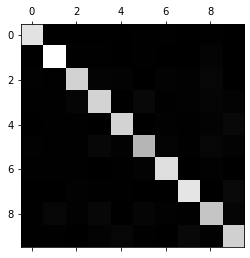

In [37]:
# Plot the confusion matrix

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [38]:
# Divide each value in the confusion matrix by the number of images in the corresponding class to give error rates

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

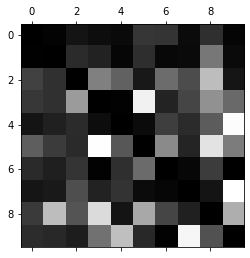

In [39]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Rows represent actual classes, while columns represent predicted classes. The column for class 8 is quite bright - this means many images get misclassified as 8s. The row for 8s is not bad, meaning 8s are generally correctly classified as 8s. You can also see that 5s and 3s get confused in both directions.

Analysing the confusion matrix often gives insights into how to improve the classifier. In this case, spending time on reducing false 8s would be useful.

### Multilabel Classification

In some cases you will want multiple classes assigned to each instance

In [40]:
# The first label indicates whether the digit is large (7, 8, 9) and the second, whether or not it is odd.

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [41]:
knn_clf.predict([some_digit])

array([[False,  True]])

There are many ways to evaluate a multilabel classifier. One approach is to measure the F<sub>1</sub> score for each individual label, then compute the average score.

In [42]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.97816498594798

This assumes that all labels are equally important which may not be the case. If there are many more instances of a class than others, you may want to weight the label equal to its *support* (the number of instances with that target label).

### Multioutput Classification

Each label can be multiclass (i.e. can have more than two possible values).

To illustrate this we can build a system that removes noise from images. It will take a noisy digit image as input and output a clean digit image, represented as an array of pixel intensities. The classifiers output is multilabel (one label per pixel) and each label can have multiple values (0 to 255).

In [43]:
# Take the MNIST images and add noise using NumPy's randint() function. The target images will be the original images

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [44]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

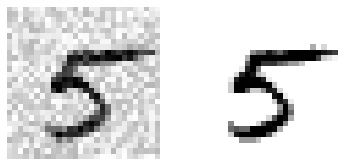

In [45]:
# Plot the noisy and original digit

some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

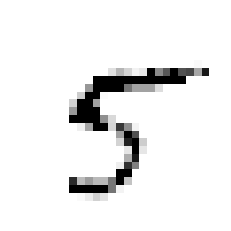

In [46]:
# Train the classifier and clean the image

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## Exercises

#### 1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set.

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'weights':['uniform', 'distance'],
     'n_neighbors':[3, 4, 5],
    }
]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5,
                          verbose=3,
                          n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [48]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [49]:
grid_search.best_score_

0.9735166666666666

In [50]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

#### 2. Write a function that can shift an MNIST image in any direction by one pixel. Then for each image create four shifted copies (one in each direction) and add to the training set. Then train the model on the expanded training set and measure its accuracy on the test set.

In [53]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])


In [54]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [55]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [56]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [57]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [58]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

#### 3. Tackle the Titanic dataset

 - Answer in other notebook

#### 4. Build a spam classifier
 - Answer in other notebook